# Ising Model

The Ising model is an important physical model, which manifest in various applications. Originally, the model was formulated to reflect interactions between magnetic dipole moments of atomic spins in lattices but since, it was found relevant to describe many systems, such as genetic markers[1], superconducting layered compounds[2], Majorana fermions[3], voter model[4].

The Ising model is essentially a second order interaction Hamiltonian, which describes the state of the system according to the Hamiltonian ground state and thermodynamical properties. As such, the Ising model is also an example of Quadratic unconstrained binary optimization (QUBO) and thus can be mapped to solve NP hard problem. For example, one can equivalently formulated a graph maximum cut (Max-Cut) to an Ising model.

Using Classiq's platform, we hereby demonstrate how to formulate the Ising model into an optimization problem, which will be sent to solution using Classiq's quantum approximated optimization algorithm (QAOA). The results of the model are obtained using execution of a quantum simulator, and can be similarly redirected to execution using other simulators or even quantum hardware (see [5] for execution options).

## 0. Pre-requirments

The model is using several Classiq's libraries in addition to basic python tools.

In [1]:
import numpy as np
import pyomo.core as pyo

## 1. Define the Optimization Problem

We created a python pyomo model to describe an Ising model as optimization problem over the configuration of spins. We take a simple manifestation of the 1d Ising model, described as [6]:

$H(\sigma) = -\sum\limits _{i,j}J\sigma_{i}\sigma_{j}-\sum\limits _{i} h\sigma_{i}$

where for any two adjacent sites $i, j$ there is an interaction $J$, and for any site $i$ there is a contribution of magnetic field $h$. Here, $\sigma$ represent the spin's value, it is discrete and can have value within the set of ${-1,1}$. We use transformation of $\sigma \rightarrow (2*z-1)$, where $z$ is a binary variable.

An option for periodic boundary condition for the 1d spin structure is embedded in the model, which declares whether the first and last spins are interacting in the model (i.e., whether the spin configuration is of closed chain, or open line).

In [2]:
def ising_model_1d(J: int, h: int, n: int, periodic: str) -> pyo.ConcreteModel:
    model = pyo.ConcreteModel("ising")

    # Define the variables:
    model.z = pyo.Var(range(n), domain=pyo.Binary)
    z_array = np.array(list(model.z.values()))

    E = lambda i, j: -J * (2 * z_array[i] - 1) * (2 * z_array[j] - 1) - (h / 2) * (
        (2 * z_array[i] - 1) + (2 * z_array[j] - 1)
    )

    # create the ising Hamiltonian
    if periodic == "True":
        model.H = E(0, n - 1)
    if periodic == "False":
        model.H = -(h / 2) * ((2 * z_array[0] - 1) + (2 * z_array[n - 1] - 1))
    for i in range(n - 1):
        model.H = model.H + E(i, i + 1)

    # setting the objective:
    model.cost = pyo.Objective(expr=model.H, sense=pyo.minimize)

    return model

## 2. Create your Ising model

The user choses what parameters of interaction coupling $J$ and magnetic field $h$ to insert, in addition to whether the boundry conditions are periodic.

In [3]:
ising_model = ising_model_1d(J=10, h=-20, n=6, periodic="True")

## 3. Optimize Using to Quantum Optimization Algorithm

We will now create a QAOA model for the optimization problem. The results of the model is the sequance of qubit values giving the minimized energy for the protein. In order to optimize the results, we recommend the user to explore the number of repatitions for the model (`num_layers`) and the number of iterations for the optimizer (`max_iteration`).

In [4]:
from classiq import construct_combinatorial_optimization_model
from classiq.applications.combinatorial_optimization import OptimizerConfig, QAOAConfig

qaoa_config = QAOAConfig(num_layers=5)

optimizer_config = OptimizerConfig(
    max_iteration=100,
    alpha_cvar=0.7,
)

qmod = construct_combinatorial_optimization_model(
    pyo_model=ising_model,
    qaoa_config=qaoa_config,
    optimizer_config=optimizer_config,
)

We also set the quantum backend we want to execute on:

In [5]:
from classiq import set_execution_preferences
from classiq.execution import ClassiqBackendPreferences, ExecutionPreferences

backend_preferences = ExecutionPreferences(
    backend_preferences=ClassiqBackendPreferences(backend_name="simulator")
)

qmod = set_execution_preferences(qmod, backend_preferences)

In [6]:
from classiq import write_qmod

write_qmod(qmod, "ising_model")

Now we can create a quantum circuit using the `synthesize` command and show it

In [7]:
from classiq import show, synthesize

qprog = synthesize(qmod)
show(qprog)

Opening: https://platform.classiq.io/circuit/77c5e7d1-82b7-4c26-ae49-54ab59fd554a?version=0.45.0.dev0%2Bcf1b9b7ccc


We now solve the problem by calling the `execute` function on the quantum program we have generated:

In [8]:
from classiq import execute

res = execute(qprog).result()

We can check the convergence of the run:

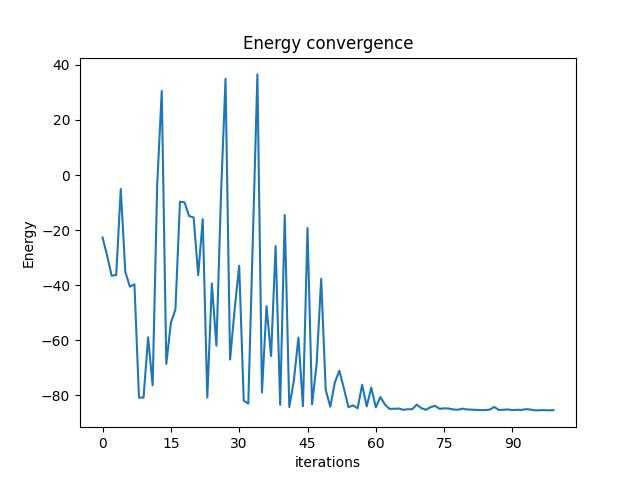

In [9]:
from classiq.execution import VQESolverResult

vqe_result = res[0].value
vqe_result.convergence_graph

## 4. Present Quantum Results

We hereby present the optimization results. Since this is a quantum solution with probabilistic results, there is a defined probability for each result to be obtained by a measurement (presented by an histogram), where the solution is chosen to be the most probable one.

We remind that in the notation of the solution "0" indicate "-1" spin value, and "1" indicates "1" spin value.

In [10]:
import pandas as pd

from classiq.applications.combinatorial_optimization import (
    get_optimization_solution_from_pyo,
)

solution = get_optimization_solution_from_pyo(
    ising_model, vqe_result=vqe_result, penalty_energy=qaoa_config.penalty_energy
)
optimization_result = pd.DataFrame.from_records(solution)
optimization_result.sort_values(by="cost", ascending=True).head(5)

,probability,cost,solution,count
0,0.139,-180.0,"[0, 0, 0, 0, 0, 0]",139
4,0.059,-100.0,"[0, 0, 0, 1, 0, 0]",59
5,0.053,-100.0,"[0, 0, 0, 0, 0, 1]",53
6,0.047,-100.0,"[1, 0, 0, 0, 0, 0]",47
7,0.047,-100.0,"[0, 1, 0, 0, 0, 0]",47


array([[<Axes: title={'center': 'cost'}>]], dtype=object)

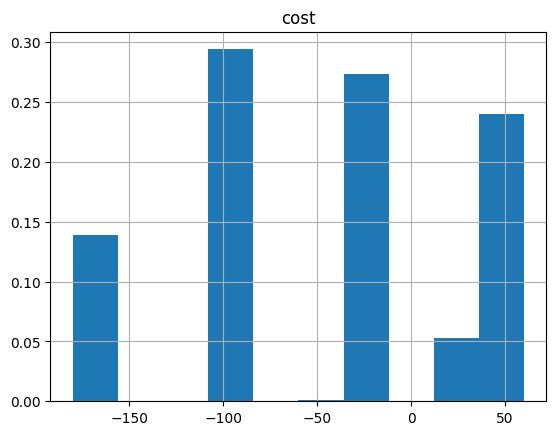

In [11]:
optimization_result.hist("cost", weights=optimization_result["probability"])

## References

[1] The Ising model in physics and statistical genetics, J. Majewski, H. Li, J. Ott.

[2] A short introduction to topological quantum computation, Ville T. Lahtinen and Jiannis K. Pachos.

[3] Recent progresses in two-dimensional Ising superconductivity, W. Li et al.

[4] Phase transition and power-law coarsening in Ising-doped voter model, Adam Lipowski, Dorota Lipowska, Antonio L. Ferreira.

[5] Classiq's user guide, execution options: https://docs.classiq.io/latest/reference-manual/executor/

[6] The Ising model in wikepidia https://en.wikipedia.org/wiki/Ising_model